1. Przegląd danych:
Podaj liczbę filmów Sci-Fi
Pokaż rozkład ocen komedii
Podaj średnią ocen wszystkich filmów akcji oraz 3 filmy najwyżej ocenianych
2. System rekomendacyjny
Zbuduj system na podstawie algorytmu SVD oraz kNNwithMeans
Czym różni się algorytm kNN with means od standardowego kNN?
Wykorzystaj metodę hiperparametryzacji GridSearch do wyboru liczby sąsiadów od 2-6
W ocenie metod wykorzystaj walidację krzyżową
3. Podaj rekomendacje po obejrzeniu filmu: Jumanji  oraz Flint

In [2]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, KNNBaseline, accuracy
from surprise.model_selection import cross_validate, GridSearchCV

ratings = pd.read_csv('ml-32m/ml-32m/ratings.csv')
movies = pd.read_csv('ml-32m/ml-32m/movies.csv')

print("\nratings.head():")
print(ratings.head())
print("\nmovies.head():")
print(movies.head())


ratings.head():
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858

movies.head():
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [2]:
sci_fi_movies = movies[movies['genres'].str.contains('Sci-Fi', na=False)]
num_sci_fi = len(sci_fi_movies)
print(f"Liczba filmów 'Sci-Fi': {num_sci_fi}")

Liczba filmów 'Sci-Fi': 4907


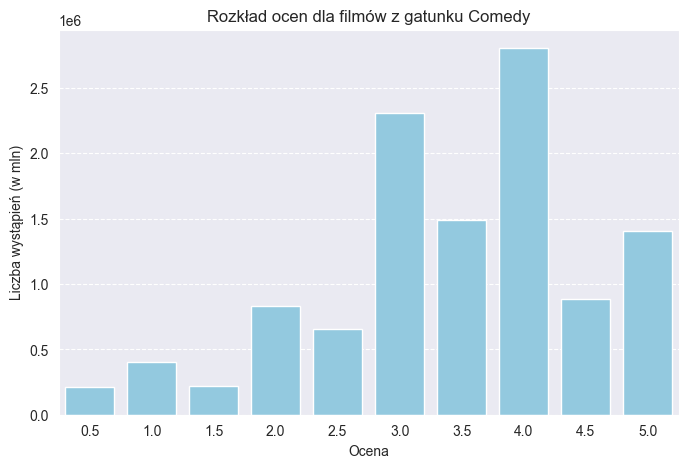

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

comedy_movies = movies[movies['genres'].str.contains('Comedy', na=False)]
comedy_ratings = ratings.merge(comedy_movies, on='movieId')


rating_distribution = comedy_ratings['rating'].value_counts().sort_index().reset_index()
rating_distribution.columns = ['rating', 'count']
rating_distribution['count'] = rating_distribution['count'].astype(int)

plt.figure(figsize=(8, 5))
sns.barplot(x=rating_distribution['rating'], y=rating_distribution['count'], color='skyblue')
plt.title('Rozkład ocen dla filmów z gatunku Comedy')
plt.xlabel('Ocena')
plt.ylabel('Liczba wystąpień (w mln)')
plt.grid(axis='y', linestyle='--')
plt.show()

In [5]:
action_movies = movies[movies['genres'].str.contains('Action', na=False)]
action_ratings = ratings.merge(action_movies, on='movieId')

# Średnia ocen wszystkich filmów 'Action'
avg_action_rating = action_ratings['rating'].mean()
print(f"Średnia ocen dla wszystkich filmów 'Action': {avg_action_rating:.2f}")

# Obliczenia Średniej Bayesa (Bayesian Average - BA)
m = ratings['rating'].mean() #

all_movie_counts = ratings.groupby('movieId')['rating'].count()
C = all_movie_counts.mean()


movie_stats = action_ratings.groupby('movieId').agg(
    N=('rating', 'count'),
    sum_ratings=('rating', 'sum')
).reset_index()

movie_stats['bayesian_average'] = (C * m + movie_stats['sum_ratings']) / (C + movie_stats['N'])

movie_stats = movie_stats.merge(action_movies[['movieId', 'title']], on='movieId')
top_3_bayesian = movie_stats.sort_values(by='bayesian_average', ascending=False).head(3)

print("\n3 najwyżej oceniane filmy 'Action' (wg średniej Bayesa):")
print(top_3_bayesian[['title', 'bayesian_average', 'N']].round(2).to_markdown(index=False, numalign="left", stralign="left"))

Średnia ocen dla wszystkich filmów 'Action': 3.48

3 najwyżej oceniane filmy 'Action' (wg średniej Bayesa):
| title                                       | bayesian_average   | N     |
|:--------------------------------------------|:-------------------|:------|
| Band of Brothers (2001)                     | 4.32               | 2811  |
| Seven Samurai (Shichinin no samurai) (1954) | 4.23               | 16531 |
| Fight Club (1999)                           | 4.23               | 77332 |


In [6]:
from scipy.sparse import csr_matrix
def create_sparse(df):
    """
    Generuje macierz rzadką w formacie CSR z ramki danych ocen.

    Args:
        df: pandas dataframe zawierający 3 kolumny (userId, movieId, rating)

    Returns:
        X: Macierz rzadka (csr_matrix)
        user_mapper, movie_mapper: Słowniki mapujące ID na indeksy (0-M/N)
        user_inv_mapper, movie_inv_mapper: Słowniki mapujące indeksy na ID
    """
    M = df['userId'].nunique() # Liczba unikalnych użytkowników
    N = df['movieId'].nunique() # Liczba unikalnych filmów

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_sparse(ratings)
sparsity = X.count_nonzero() / (X.shape[0] * X.shape[1])

print(f"Kształt macierzy X (Użytkownicy x Filmy): {X.shape[0]} x {X.shape[1]}")
print(f"Liczba niezerowych elementów: {X.count_nonzero()}")
print(f"Matrix sparsity (Rzadkość): {round(sparsity*100, 2)}%")


Kształt macierzy X (Użytkownicy x Filmy): 200948 x 84432
Liczba niezerowych elementów: 32000204
Matrix sparsity (Rzadkość): 0.19%


Algorytm kNN with means różni się od standardowego kNN tym, że zamiast klasyfikować nową próbkę na podstawie większości głosów k najbliższych sąsiadów, przypisuje jej klasę, której średnia cech (centroid) jest do niej najbliższa. W efekcie, w kNN with means, faktyczna klasyfikacja zależy od porównania odległości do centroidów, a nie od indywidualnych etykiet sąsiadów.

In [7]:
from surprise import Reader, Dataset
from surprise import SVD, KNNWithMeans
from surprise.model_selection import cross_validate, GridSearchCV
import numpy as np

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

print("1. SVD")
algo_svd = SVD(random_state=42)
cv_results_svd = cross_validate(algo_svd, data, measures=['RMSE'], cv=3, verbose=False)

mean_rmse_svd = np.mean(cv_results_svd['test_rmse'])
print(f"Średni RMSE (SVD): {mean_rmse_svd:.4f}")

print("2. Hiperparametryzacja kNNwithMeans (Grid Search)")

k_values = list(range(2, 7))
param_grid = {
    'k': k_values,
    'sim_options': {
        'name': ['pearson'],
        'user_based': [False] # Użycie Item-based
    }
}

print(f"Testowane wartości k: {k_values}")
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

best_rmse = gs.best_score['rmse']
best_params_rmse = gs.best_params['rmse']
best_algo = gs.best_estimator['rmse']

print("\n--- WYNIKI OPTYMALIZACJI kNNwithMeans ---")
print(f"Najlepszy RMSE: {best_rmse:.4f}")
print(f"Optymalne parametry dla RMSE: {best_params_rmse}")
print(f"Wybrany optymalny model: {best_algo.__class__.__name__} z k={best_algo.k}")
#wynik: Średni RMSE (SVD): 0.7816

1. SVD
Średni RMSE (SVD): 0.7816
2. Hiperparametryzacja kNNwithMeans (Grid Search)
Testowane wartości k: [2, 3, 4, 5, 6]
Computing the pearson similarity matrix...


MemoryError: Unable to allocate 44.0 GiB for an array with shape (76882, 76882) and data type float64

In [2]:
#Z powodu MemoryError przeprowadzam na mniejszej liczbie filmów i ocen
from surprise import Reader, Dataset
from surprise import SVD, KNNWithMeans
from surprise.model_selection import cross_validate, GridSearchCV
import numpy as np

#Obliczenie liczby ocen dla każdego filmu
MIN_RATINGS_THRESHOLD = 1000
movie_counts = ratings.groupby('movieId')['rating'].count()
popular_movies_ids = movie_counts[movie_counts >= MIN_RATINGS_THRESHOLD].index

#Utworzenie podzbioru ocen
ratings_subset = ratings[ratings['movieId'].isin(popular_movies_ids)].copy()

#Ograniczenie użytkowników
user_counts = ratings_subset.groupby('userId')['rating'].count()
popular_users_ids = user_counts[user_counts >= 5].index
ratings_subset = ratings_subset[ratings_subset['userId'].isin(popular_users_ids)]

SAMPLE_SIZE_MILLIONS = 10
SAMPLE_FRACTION = 10_000_000 / len(ratings_subset)

if SAMPLE_FRACTION < 0.01:
    SAMPLE_FRACTION = 0.01

print(f"Obecny zbiór ma {len(ratings_subset):,} ocen. Pobieram losową próbkę ({SAMPLE_FRACTION*100:.2f}%).")

ratings_sample = ratings_subset.sample(frac=SAMPLE_FRACTION, random_state=42).copy()



print(f"Grid Search na próbce: {len(ratings_sample):,} ocen")
reader = Reader(rating_scale=(0.5, 5.0))
data_sample = Dataset.load_from_df(ratings_sample[['userId', 'movieId', 'rating']], reader)

k_values = list(range(2, 7))
param_grid = {
    'k': k_values,
    'sim_options': {
        'name': ['pearson'],
        'user_based': [False]
    }
}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3, n_jobs=1)
gs.fit(data_sample)

best_params_rmse = gs.best_params['rmse']

print("\n--- WYNIKI (na próbce) ---")
print(f"Optymalne parametry k: {best_params_rmse}")

Obecny zbiór ma 28,528,210 ocen. Pobieramy losową próbkę (35.05%).
Grid Search na próbce: 10,000,000 ocen
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done

In [7]:
from surprise import Reader, Dataset
from surprise import SVD, KNNWithMeans
from surprise.model_selection import cross_validate, GridSearchCV
import numpy as np

MIN_RATINGS_THRESHOLD = 1000
movie_counts = ratings.groupby('movieId')['rating'].count()
popular_movies_ids = movie_counts[movie_counts >= MIN_RATINGS_THRESHOLD].index
ratings_subset = ratings[ratings['movieId'].isin(popular_movies_ids)].copy()
#optymalne paramatry
FINAL_K = 6
FINAL_SIM_OPTIONS = {'name': 'pearson', 'user_based': False}
reader = Reader(rating_scale=(0.5, 5.0))
data_subset = Dataset.load_from_df(ratings_subset[['userId', 'movieId', 'rating']], reader)

final_algo_knn = KNNWithMeans(k=FINAL_K, sim_options=FINAL_SIM_OPTIONS)
trainset = data_subset.build_full_trainset()
final_algo_knn.fit(trainset)
print(f"Ostateczny model kNNwithMeans (k={FINAL_K}) wytrenowany pomyślnie.")

Computing the pearson similarity matrix...
Done computing similarity matrix.
Ostateczny model kNNwithMeans (k=6) wytrenowany pomyślnie.


In [9]:
pattern = r'\bJumanji\b'
jumanji_movies = movies[movies['title'].str.contains(pattern, case=False, na=False, regex=True)].copy()
if not jumanji_movies.empty:
    print(jumanji_movies[['movieId', 'title']].to_markdown(index=False))
else:
    print("Brak filmów z dokładnym słowem 'Jumanji' w tytule.")

|   movieId | title                                 |
|----------:|:--------------------------------------|
|         2 | Jumanji (1995)                        |
|    179401 | Jumanji: Welcome to the Jungle (2017) |
|    207233 | Jumanji: The Next Level (2019)        |


In [8]:
pattern = r'\bFlint\b'
flint_movies = movies[movies['title'].str.contains(pattern, case=False, na=False, regex=True)].copy()
if not flint_movies.empty:
    print(flint_movies[['movieId', 'title']].to_markdown(index=False))
else:
    print("Brak filmów z dokładnym słowem 'Flint' w tytule.")

Filmy pasujące dokładnie do słowa 'Flint' i ich ID:
|   movieId | title                |
|----------:|:---------------------|
|      5493 | In Like Flint (1967) |
|      5497 | Our Man Flint (1965) |
|    193585 | Flint (2017)         |


In [ ]:
jumanji_id = 2
flint_id = 193585
movie_titles = dict(zip(movies['movieId'], movies['title']))
def get_similar_movies_knn(model, top_n=5, target_ids=[]):
    """zoptymalizowany model Item-Based do znalezienia sąsiadów."""
    recommendations = {}

    for movie_id in target_ids:
        try:
            movie_inner_id = model.trainset.to_inner_iid(movie_id)
            neighbors_inner_ids = model.get_neighbors(movie_inner_id, k=top_n)

            neighbors_external_ids = [model.trainset.to_raw_iid(inner_id) for inner_id in neighbors_inner_ids]

            final_recs = [movie_titles[mid] for mid in neighbors_external_ids if mid != movie_id and mid in movie_titles]

            recommendations[movie_id] = final_recs
        except ValueError:
            recommendations[movie_id] = [f"Brak wystarczających danych do predykcji dla ID {movie_id}."]

    return recommendations


target_list = [jumanji_id, flint_id]
recs = get_similar_movies_knn(best_algo, top_n=5, target_ids=target_list)

print(f" k={best_algo.k} (Item-Based):")

print(f"Jeśli podobał Ci się {movie_titles[jumanji_id]} (ID: {jumanji_id}), rekomendujemy:")
for title in recs[jumanji_id]:
    print(f"- {title}")


print(f"Jeśli podobał Ci się {movie_titles[flint_id]} (ID: {flint_id}), rekomendujemy:")
for title in recs[flint_id]:
    print(f"- {title}")

In [9]:
movie_titles = dict(zip(movies['movieId'], movies['title']))
jumanji_id = 2
flint_id = 193585

def get_similar_movies_knn(model, top_n=5, target_ids=[]):
    """zoptymalizowany model Item-Based do znalezienia sąsiadów."""
    recommendations = {}

    for movie_id in target_ids:
        try:
            movie_inner_id = model.trainset.to_inner_iid(movie_id)
            neighbors_inner_ids = model.get_neighbors(movie_inner_id, k=top_n)

            neighbors_external_ids = [model.trainset.to_raw_iid(inner_id) for inner_id in neighbors_inner_ids]
            final_recs = [movie_titles[mid] for mid in neighbors_external_ids if mid != movie_id and mid in movie_titles]

            recommendations[movie_id] = final_recs
        except ValueError:
            recommendations[movie_id] = [f"Brak wystarczających danych do predykcji dla ID {movie_id}."]

    return recommendations


target_list = [jumanji_id, flint_id]
recs = get_similar_movies_knn(final_algo_knn, top_n=5, target_ids=target_list)
print(f" k={final_algo_knn.k} (Item-Based):")

print(f"Jeśli podobał Ci się {movie_titles[jumanji_id]} (ID: {jumanji_id}), rekomendujemy:")
for title in recs[jumanji_id]:
    print(f"- {title}")


print(f"Jeśli podobał Ci się {movie_titles[flint_id]} (ID: {flint_id}), rekomendujemy:")
for title in recs[flint_id]:
    print(f"- {title}")

 k=6 (Item-Based):
Jeśli podobał Ci się Jumanji (1995) (ID: 2), rekomendujemy:
- Eddie (1996)
- Flubber (1997)
- Beethoven (1992)
- Casper (1995)
- Man of the House (1995)
Jeśli podobał Ci się Flint (2017) (ID: 193585), rekomendujemy:
- Brak wystarczających danych do predykcji dla ID 193585.
